# ----------------------------------------------------
# 0) Importing libraries
# ----------------------------------------------------

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1) Read and cleaning the Excel file
# ----------------------------------------------------

In [41]:
raw = pd.read_excel("WRSAM-Data.xls", sheet_name="Headflow")

# The first row contains the true column headers
new_cols = raw.iloc[0].tolist()
df = raw.iloc[1:].copy()
df.columns = new_cols

# Monthly column names in the dataset
months = ["MEH", "ABA", "AZA", "DEY", "BAH", "ESF",
          "FAR", "ORD", "KHO", "TIR", "MOR", "SHA"]

# Keep only Year + monthly inflow columns
df = df[["Year"] + months]

# Convert inflow values to numeric format
for m in months:
    df[m] = pd.to_numeric(df[m], errors="coerce")


# ----------------------------------------------------
# 2) Convert discharge (m³/s) into monthly volumes (m³/month)
# Persian calendar month lengths are assumed
# ----------------------------------------------------

In [43]:
month_days = {
    "MEH": 30, "ABA": 30, "AZA": 30, "DEY": 30, "BAH": 30, "ESF": 29,
    "FAR": 31, "ORD": 31, "KHO": 31, "TIR": 31, "MOR": 31, "SHA": 31
}

# Seconds per month
secs = np.array([month_days[m] * 24 * 3600 for m in months], dtype=float)

# Discharge inflow matrix (m³/s)
Q = df[months].to_numpy(float)

# Monthly inflow volume matrix (m³/month)
V = Q * secs


# ----------------------------------------------------
# 3) Reservoir simulation and reliability calculation
## Time-based reliability for constant yield Y
###    V_2d : monthly inflow volumes (m³/month), shape (years, 12)
###    K    : storage capacity (m³)
###    Y    : constant monthly demand/yield (m³/month)
# ----------------------------------------------------

In [45]:
def reliability_given_K_Y(V_2d, K, Y):
    # Repeat the record 3 times to reduce initial-condition effects
    series = np.tile(V_2d, (3, 1)).reshape(-1)

    N = V_2d.shape[0] * 12
    start, end = N, 2 * N  # evaluate only the middle cycle

    # Start reservoir full (conservative assumption)
    S = K

    fails = 0
    total = 0

    for t in range(3 * N):

        available = S + series[t]
        release = min(Y, available)

        # Count failures only in the middle cycle
        if start <= t < end:
            total += 1
            if release + 1e-6 < Y:
                fails += 1

        # Update storage
        S = min(K, available - release)
        if S < 0:
            S = 0.0

    return 1 - fails / total


# ----------------------------------------------------
# 4) For each storage K, find the maximum yield Y
# that achieves the target reliability (bisection method)
# ----------------------------------------------------

In [47]:
def max_yield_for_target(V_2d, K, R_target):

    # Safe upper bound for yield
    y_hi = np.nanmax(V_2d) + K

    # If even the upper bound meets reliability, return it
    if reliability_given_K_Y(V_2d, K, y_hi) >= R_target:
        return y_hi

    # Bisection search
    lo, hi = 0.0, y_hi
    for _ in range(50):
        mid = (lo + hi) / 2
        r = reliability_given_K_Y(V_2d, K, mid)

        if r >= R_target:
            lo = mid
        else:
            hi = mid

    return lo


# ----------------------------------------------------
# 5) Build Storage–Yield curves for different reliabilities
# ----------------------------------------------------

In [ ]:
targets = [1.00, 0.95, 0.90, 0.80]

# Storage grid (m³)
K_grid = np.linspace(0, 1e9, 140)

# Compute yield curves
Y_curves = {}
for R in targets:
    Y_curves[R] = np.array([max_yield_for_target(V, K, R) for K in K_grid])


# ----------------------------------------------------
# 6) Plot final Storage–Yield–Reliability curves
# ----------------------------------------------------

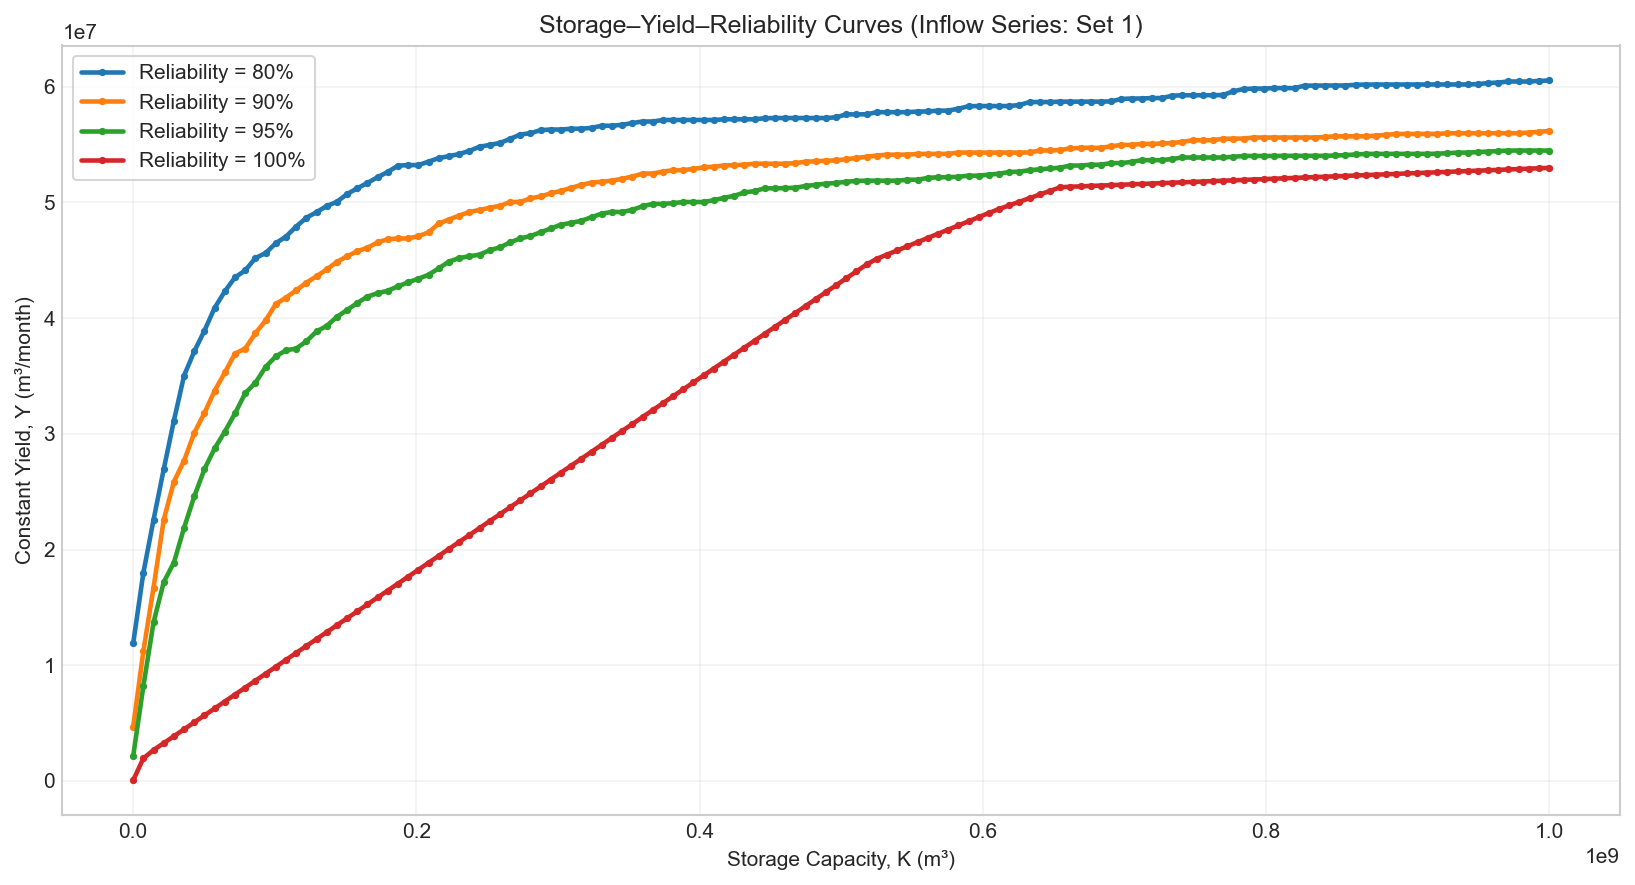

In [33]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(11, 6), dpi=150)

# Plot curves in standard order
for R in [0.80, 0.90, 0.95, 1.00]:
    plt.plot(
        K_grid,
        Y_curves[R],
        linewidth=2.2,
        marker="o",
        markersize=2.5,
        label=f"Reliability = {int(R*100)}%"
    )
plt.xlabel("Storage Capacity, K (m³)")
plt.ylabel("Constant Yield, Y (m³/month)")
plt.title("Storage–Yield–Reliability Curves (Inflow Series: Set 1)")
plt.grid(True, alpha=0.25)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()
